In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [3]:
def generate_heatmap(data, target):
    
    import seaborn as sns
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    # Generate a correlation heatmap matrix of the numerical features in the training data set.
    numeric_data = data.select_dtypes(include=['integer', 'float'])
   
    results = numeric_data.corr() 
    sorted_corrs = results[target].abs().sort_values()

    # get the columns with a strong correlation from our .corr() list
    strong_corrs = sorted_corrs[sorted_corrs > 0.4]

    # get the correlation of the strongly correlated columns with each other from the orginal dataset
    corrmat = numeric_data[strong_corrs.index].corr().abs()

    sns.set(style="white")
    mask = np.zeros_like(corrmat, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True)
    sns.heatmap(corrmat, mask=mask, cmap=cmap, square=True, linewidths=.25, cbar_kws={"shrink": .5})
            
    return


In [4]:
def drop_low_corr_cols(data, threshold, target):
    
    numeric_data = data.select_dtypes(include=['integer', 'float'])
  
    results = numeric_data.corr() 
    sorted_corrs = results[target].abs().sort_values()

    # get the columns with a strong correlation from our .corr() list
    low_corrs = sorted_corrs[sorted_corrs < threshold]
    
    #print("Low correlation cols to drop:",low_corrs.index)
    
    data = data.drop(low_corrs.index,axis=1)
    
    return data


In [5]:
def transform_features(data):

    # Exclude anything with over 5% null values
    sum_of_nulls = data.isnull().sum().sort_values()
    cols_to_drop = sum_of_nulls[sum_of_nulls > len(data)/20].index
    data = data.drop(cols_to_drop, axis=1)

    # From the remaining data, exclude and TEXT columns that have ANY nulls
    text_null_count = data.select_dtypes(include=['object']).isnull().sum().sort_values()
    text_cols_to_drop = text_null_count[text_null_count > 0].index
    data = data.drop(text_cols_to_drop, axis=1)   

    # Fill in remaining NUMERIC columns null values with most popular values for each column
    numeric_null_count = data.select_dtypes(include=['float','int']).isnull().sum().sort_values()
    cols_to_fill = numeric_null_count[numeric_null_count >0].index
    vals_to_use = data[cols_to_fill].mode()

    for col in cols_to_fill:
        value = vals_to_use[col][0]
        data[col] = data[col].fillna(value)

    # Create some new features (age_at_sale, years_since_remod) & drop rows where value is <0
    data['Age at Sale'] = data['Yr Sold'] - data['Year Built']
    rows_to_drop = data[data['Age at Sale']<0].index
    data = data.drop(rows_to_drop,axis=0)

    data['Years Since Remod'] = data['Yr Sold'] - data['Year Remod/Add']
    rows_to_drop = data[data['Years Since Remod']<0].index
    data = data.drop(rows_to_drop, axis=0)

    # Drop original columns now we have more useful ones
    data = data.drop(['Yr Sold','Year Remod/Add','Year Built'], axis=1)

    # Drop columns that aren't useful for ML
    data = data.drop(['PID', 'Order'], axis=1)

    # Drop columns that 'leak' info about the final sale
    data = data.drop(['Mo Sold', 'Sale Condition', 'Sale Type'], axis=1)

    return data


In [6]:
def select_features(data, max_categories =10, max_percent=100):
    
    # Start with a list of column based on documentation
    ## IDEA: Turn 'Neighbourhood' into something more useful like distance from City Centre
    categorical_cols = ['MS SubClass', 'MS Zoning', 'Street', 'Land Contour', 'Lot Config', 'Neighborhood', 
                        'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 
                        'Exterior 2nd', 'Foundation', 'Heating', 'Central Air', 'Lot Shape','Utilities','Land Slope','Exter Qual','Exter Cond', 'Heating QC']
    total_rows = len(data)
    cols_to_remove = []

    for col in categorical_cols: 

        # get the columns that have too many categories to turn into dummies
        value_counts = data[col].value_counts()  
        if len(value_counts) > max_categories:
            cols_to_remove.append(col)
            #print('Col being removed as too many categories:',col)
        
        # get the columns that have mostly a single value
        for val, cnt in value_counts.iteritems():
            percent = round(abs(cnt/total_rows * 100),0)
            if percent > max_percent:
                cols_to_remove.append(col)
    
    data = data.drop(cols_to_remove, axis=1)
    
    # rebuilt the list of remaining columns
    for col in cols_to_remove: 
        categorical_cols.remove(col)
  
    # create dummies for the remaining columns, drop original column
    for col in categorical_cols:
        
        dummies = pd.get_dummies(data[col],prefix=col)
        data = pd.concat([data,dummies],axis=1)
        data = data.drop(col,axis=1)
        
    # drop columns that are not highly correlated with the saleprice
    data = drop_low_corr_cols(data, 0.4, 'SalePrice')

    return data


In [7]:
def train_and_test(data, k=0):
       
    from sklearn.model_selection import cross_val_score, KFold

    # select the numeric column names that are remaining, drop the target name from the list to use as features
    target = 'SalePrice'
    features = data.select_dtypes(include=['integer', 'float']).columns.drop(target)
    lr = LinearRegression()
    rmse_values = []
    
    if k == 0:
        
        # Perform holdout validation NB No data Shuffle!
        train = data[:1460]
        test = data[1460:]
        
        lr.fit(train[features], train[target])
        predictions = lr.predict(test[features])
        mse = mean_squared_error(predictions, test[target])
        
        rmse_values.append(np.sqrt(mse))
    
    elif k == 1:
        
        # Perform simple cross validation
        shuffled_df = data.sample(frac=1, )
        fold_one = shuffled_df[:1460]
        fold_two = shuffled_df[1460:]
            
        #Train on fold_one and test on fold_two
        lr.fit(fold_one[features], fold_one[target])
        predictions = lr.predict(fold_two[features])
        mse = mean_squared_error(predictions, fold_two[target])
        rmse_values.append(np.sqrt(mse))
            
        #Train on fold_two and test on fold_one
        lr.fit(fold_two[features], fold_two[target])
        predictions = lr.predict(fold_one[features])
        mse = mean_squared_error(predictions, fold_one[target])
        rmse_values.append(np.sqrt(mse))
        
    else:
        
        # Perform k-fold cross validation using k folds.
        kf = KFold(n_splits=k, shuffle=True)
        
        for train_index, test_index, in kf.split(data):
            train = data.iloc[train_index]
            test = data.iloc[test_index]
            lr.fit(train[features], train[target])
            predictions = lr.predict(test[features])
            mse = mean_squared_error(test[target], predictions)
            rmse_values.append(np.sqrt(mse))
    
    return np.mean(rmse_values)
            

In [8]:
# MAIN

data = pd.read_csv('AmesHousing.tsv',delimiter='\t')
transformed_data = transform_features(data)
selected_data = select_features(transformed_data)

print("Holdout Validation RMSE:", train_and_test(selected_data))
print("Simple cross validation RMSE:", train_and_test(selected_data, 1))
print("2 Folds average RMSE:",train_and_test(selected_data, 2))
print("5 Folds average RMSE:",train_and_test(selected_data, 5))
print("10 Folds average RMSE:",train_and_test(selected_data, 10))

Holdout Validation RMSE: 35211.0242871
Simple cross validation RMSE: 31347.4278774
2 Folds average RMSE: 32236.6368529
5 Folds average RMSE: 31190.1158503
10 Folds average RMSE: 30931.7030091


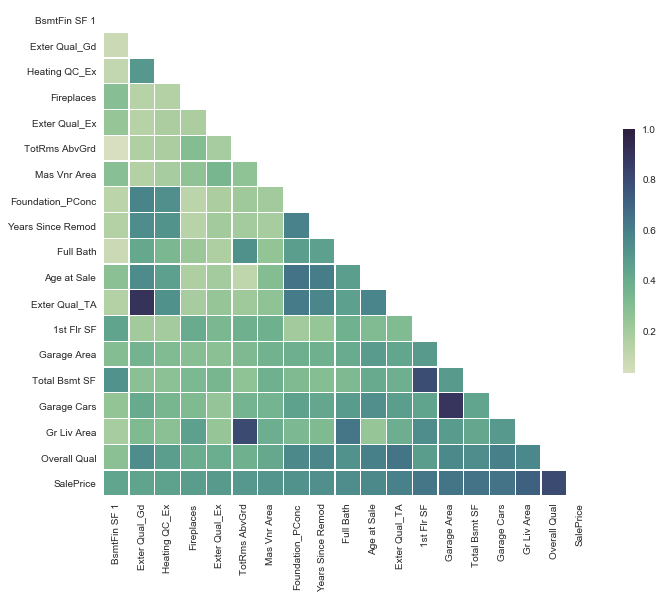

In [9]:
# show the features correlation on a heatmap, ordered (x axis) by correlation to SalePrice
generate_heatmap(selected_data, 'SalePrice')

In [10]:
# based on heatmap, drop a few highly correlated columns
candidates_to_drop = ['Exter Qual_GD', 'TotRms AbvGrd', 'Garage Area', '1st Flr SF']